This notebook shows the application of LSTM to predict the global temperature map.

By Weiwei Zhan

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
from utils import * 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

2023-01-04 01:43:22.277611: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
cwd = os.getcwd()
train_path = "gs://leap-persistent/jbusecke/data/climatebench/train_val/"
test_path = "gs://leap-persistent/jbusecke/data/climatebench/test/"

### 1. data preprocssing: prepare data for training & test sets

#### import data as training & test sets

In [3]:
# Training set
train_files = ["historical", "ssp585", "ssp126", "ssp370","hist-aer","hist-GHG"]
X_train_xr, X_length  = prepare_predictor(train_files,train_path)
y_train_xr, y_length  = prepare_predictand(train_files,train_path)

# Test set
X_test_xr, _ = prepare_predictor('ssp245', data_path=test_path,time_reindex=False)
y_test_xr, _ = prepare_predictand('ssp245',data_path=test_path,time_reindex=False)

#### select relevant variables

In [4]:
X_train_df = pd.DataFrame({"CO2": X_train_xr["CO2"].data,
                           "CH4": X_train_xr["CH4"].data
                          }, index=X_train_xr["CO2"].coords['time'].data)

X_test_df  = pd.DataFrame({"CO2": X_test_xr["CO2"].data,
                           "CH4": X_test_xr["CH4"].data
                          }, index=X_test_xr["CO2"].coords['time'].data)


y_train_df = y_train_xr["tas"].stack(dim=["latitude", "longitude"])
y_train_df = pd.DataFrame(y_train_df.to_pandas())

In [5]:
X_train_df.head()

,CO2,CH4
0,0.188297,0.031306
1,0.377244,0.031742
2,0.573814,0.032178
3,0.778848,0.032614
4,1.020320,0.033049


In [6]:
y_train_df.head()

latitude      -90.0                                                    \
longitude     0.0       2.5       5.0       7.5       10.0      12.5    
time                                                                    
0          0.320023  0.319946  0.319865  0.319885  0.319860  0.319865   
1         -0.667297 -0.667023 -0.667114 -0.667109 -0.667109 -0.667135   
2         -0.058345 -0.058167 -0.058248 -0.058243 -0.058248 -0.058248   
3          0.125870  0.125941  0.125946  0.125941  0.125946  0.125890   
4          0.418304  0.418533  0.418503  0.418523  0.418477  0.418513   

latitude                                           ...      90.0            \
longitude     15.0      17.5      20.0      22.5   ...     335.0     337.5   
time                                               ...                       
0          0.319870  0.319911  0.319763  0.319707  ...  0.913116  0.913289   
1         -0.667114 -0.667104 -0.667104 -0.666992  ...  0.042501  0.042679   
2         -0.058233 -0.058207 -0.058345 -0.058177  ...  1.167440  1.167389   
3          0.125951  0.125941  0.125895  0.125982  ... -0.339457 -0.339589   
4          0.418503  0.418549  0.418482  0.418564  ...  0.577006  0.576996   

latitude                                                               \
longitude     340.0     342.5     345.0     347.5     350.0     352.5   
time                                                                    
0          0.913116  0.912933  0.912893  0.912659  0.912384  0.912181   
1          0.049225  0.055695  0.055506  0.055227  0.054789  0.054230   
2          1.169657  1.172119  1.172201  1.172190  1.172292  1.172424   
3         -0.332387 -0.324961 -0.324956 -0.325038 -0.325063 -0.325033   
4          0.585297  0.593811  0.593740  0.593719  0.593648  0.593801   

latitude                       
longitude     355.0     357.5  
time                           
0          0.911825  0.911611  
1          0.053604  0.052897  
2          1.172709  1.173228  
3         -0.325022 -0.324880  
4          0.593760  0.593943  

[5 rows x 13824 columns]

#### Data normalization

In [7]:
# Standardization
mean, std = X_train_df.mean(), X_train_df.std()

X_train_df   = (X_train_df - mean)/std
X_test_df    = (X_test_df - mean)/std

X_train = X_train_df.to_numpy()
y_train = y_train_df.to_numpy()
X_test = X_test_df.to_numpy()

print(X_train.shape,y_train.shape,X_test.shape)

(753, 2) (753, 13824) (86, 2)


#### Reshape data to feed into the LSTM model

The LSTM needs data with the format of **[samples, time steps, features]**

Here the lag time step is set to **5**

In [8]:
start = np.cumsum(X_length) - X_length
end   = np.cumsum(X_length)

slider = 5
X_train_all = []
y_train_all = []

for i in range(len(X_length)):
    
    X_subset = X_train[start[i]:end[i],:]
    y_subset = y_train[start[i]:end[i],:]
    
    X_subset = np.array([X_subset[i:i+slider] for i in range(0, X_length[i]-slider+1)])
    y_subset = np.array([[y_subset[i+slider-1]] for i in range(0, X_length[i]-slider+1)])
    
    X_train_all.append(X_subset)
    y_train_all.append(y_subset)
    
X_train = np.concatenate(X_train_all,axis=0)
y_train = np.concatenate(y_train_all,axis=0)
X_test  = np.array([X_test[i:i+slider] for i in range(0, X_test.shape[0]-slider+1)])
print(X_train.shape,y_train.shape,X_test.shape)

(729, 5, 2) (729, 1, 13824) (82, 5, 2)


### 2. Define the LSTM structure

In [9]:
# set hyperparameters
n_neuron       = 64
activation     = 'relu'
num_epochs     = 50
learning_rate  = 0.001
minibatch_size = 64
model_num      = 1

In [10]:
lstm_model = Sequential()
lstm_model.add(LSTM(n_neuron,input_shape=(X_train.shape[1],X_train.shape[2]),
               return_sequences=True,activation=activation))
lstm_model.add(LSTM(n_neuron,return_sequences=False,
               activation=activation))
lstm_model.add(Dense(n_neuron,activation=activation))
lstm_model.add(Dense(y_train.shape[-1],activation='linear')) 

lstm_model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

lstm_model.summary()

2023-01-04 01:44:10.360993: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/nvidia/lib64
2023-01-04 01:44:10.361059: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 64)             17152     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 13824)             898560    
                                                                 
Total params: 952,896
Trainable params: 952,896
Non-trainable params: 0
_________________________________________________________________


### 3. Train & save the NN model

In [11]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = lstm_model.fit(X_train, y_train, 
                        batch_size = minibatch_size,
                        epochs = num_epochs,
                        validation_split=0.2, verbose=1,
                        callbacks=[early_stop],
                        shuffle=False)


Epoch 1/50
10/10 [==============================] - 15s 1s/step - loss: 3.7946 - val_loss: 0.5853
Epoch 2/50
10/10 [==============================] - 10s 1s/step - loss: 3.7692 - val_loss: 0.5737
Epoch 3/50
10/10 [==============================] - 10s 1s/step - loss: 3.7115 - val_loss: 0.5502
Epoch 4/50
10/10 [==============================] - 11s 1s/step - loss: 3.5492 - val_loss: 0.5004
Epoch 5/50
10/10 [==============================] - 10s 994ms/step - loss: 3.0647 - val_loss: 0.4126
Epoch 6/50
10/10 [==============================] - 11s 1s/step - loss: 2.7321 - val_loss: 0.3726
Epoch 7/50
10/10 [==============================] - 10s 1s/step - loss: 2.3565 - val_loss: 0.3615
Epoch 8/50
10/10 [==============================] - 10s 1s/step - loss: 2.2670 - val_loss: 0.3132
Epoch 9/50
10/10 [==============================] - 11s 1s/step - loss: 2.1192 - val_loss: 0.2859
Epoch 10/50
10/10 [==============================] - 10s 1s/step - loss: 1.9717 - val_loss: 0.2767
Epoch 11/50
10/1

In [12]:
model_path = os.path.join(cwd,'saved_model')
make_dir(model_path)

In [13]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
lstm_model.save(os.path.join(model_path,'LSTM_model.h5'))

### 4. Evaluate the trained model

In [14]:
# reload the saved model
lstm_model = load_model(os.path.join(model_path,'LSTM_model.h5'))

In [15]:
y_test_pre = lstm_model.predict(X_test)
y_test_pre = y_test_pre.reshape(y_test_pre.shape[0], 96, 144)

y_test_pre = xr.Dataset(coords={'time': X_test_xr.time.values[slider-1:], 
                               'latitude': X_test_xr.latitude.values, 
                               'longitude': X_test_xr.longitude.values},
                       data_vars=dict(tas=(['time', 'latitude', 'longitude'], y_test_pre)))

3/3 [==============================] - 0s 12ms/step


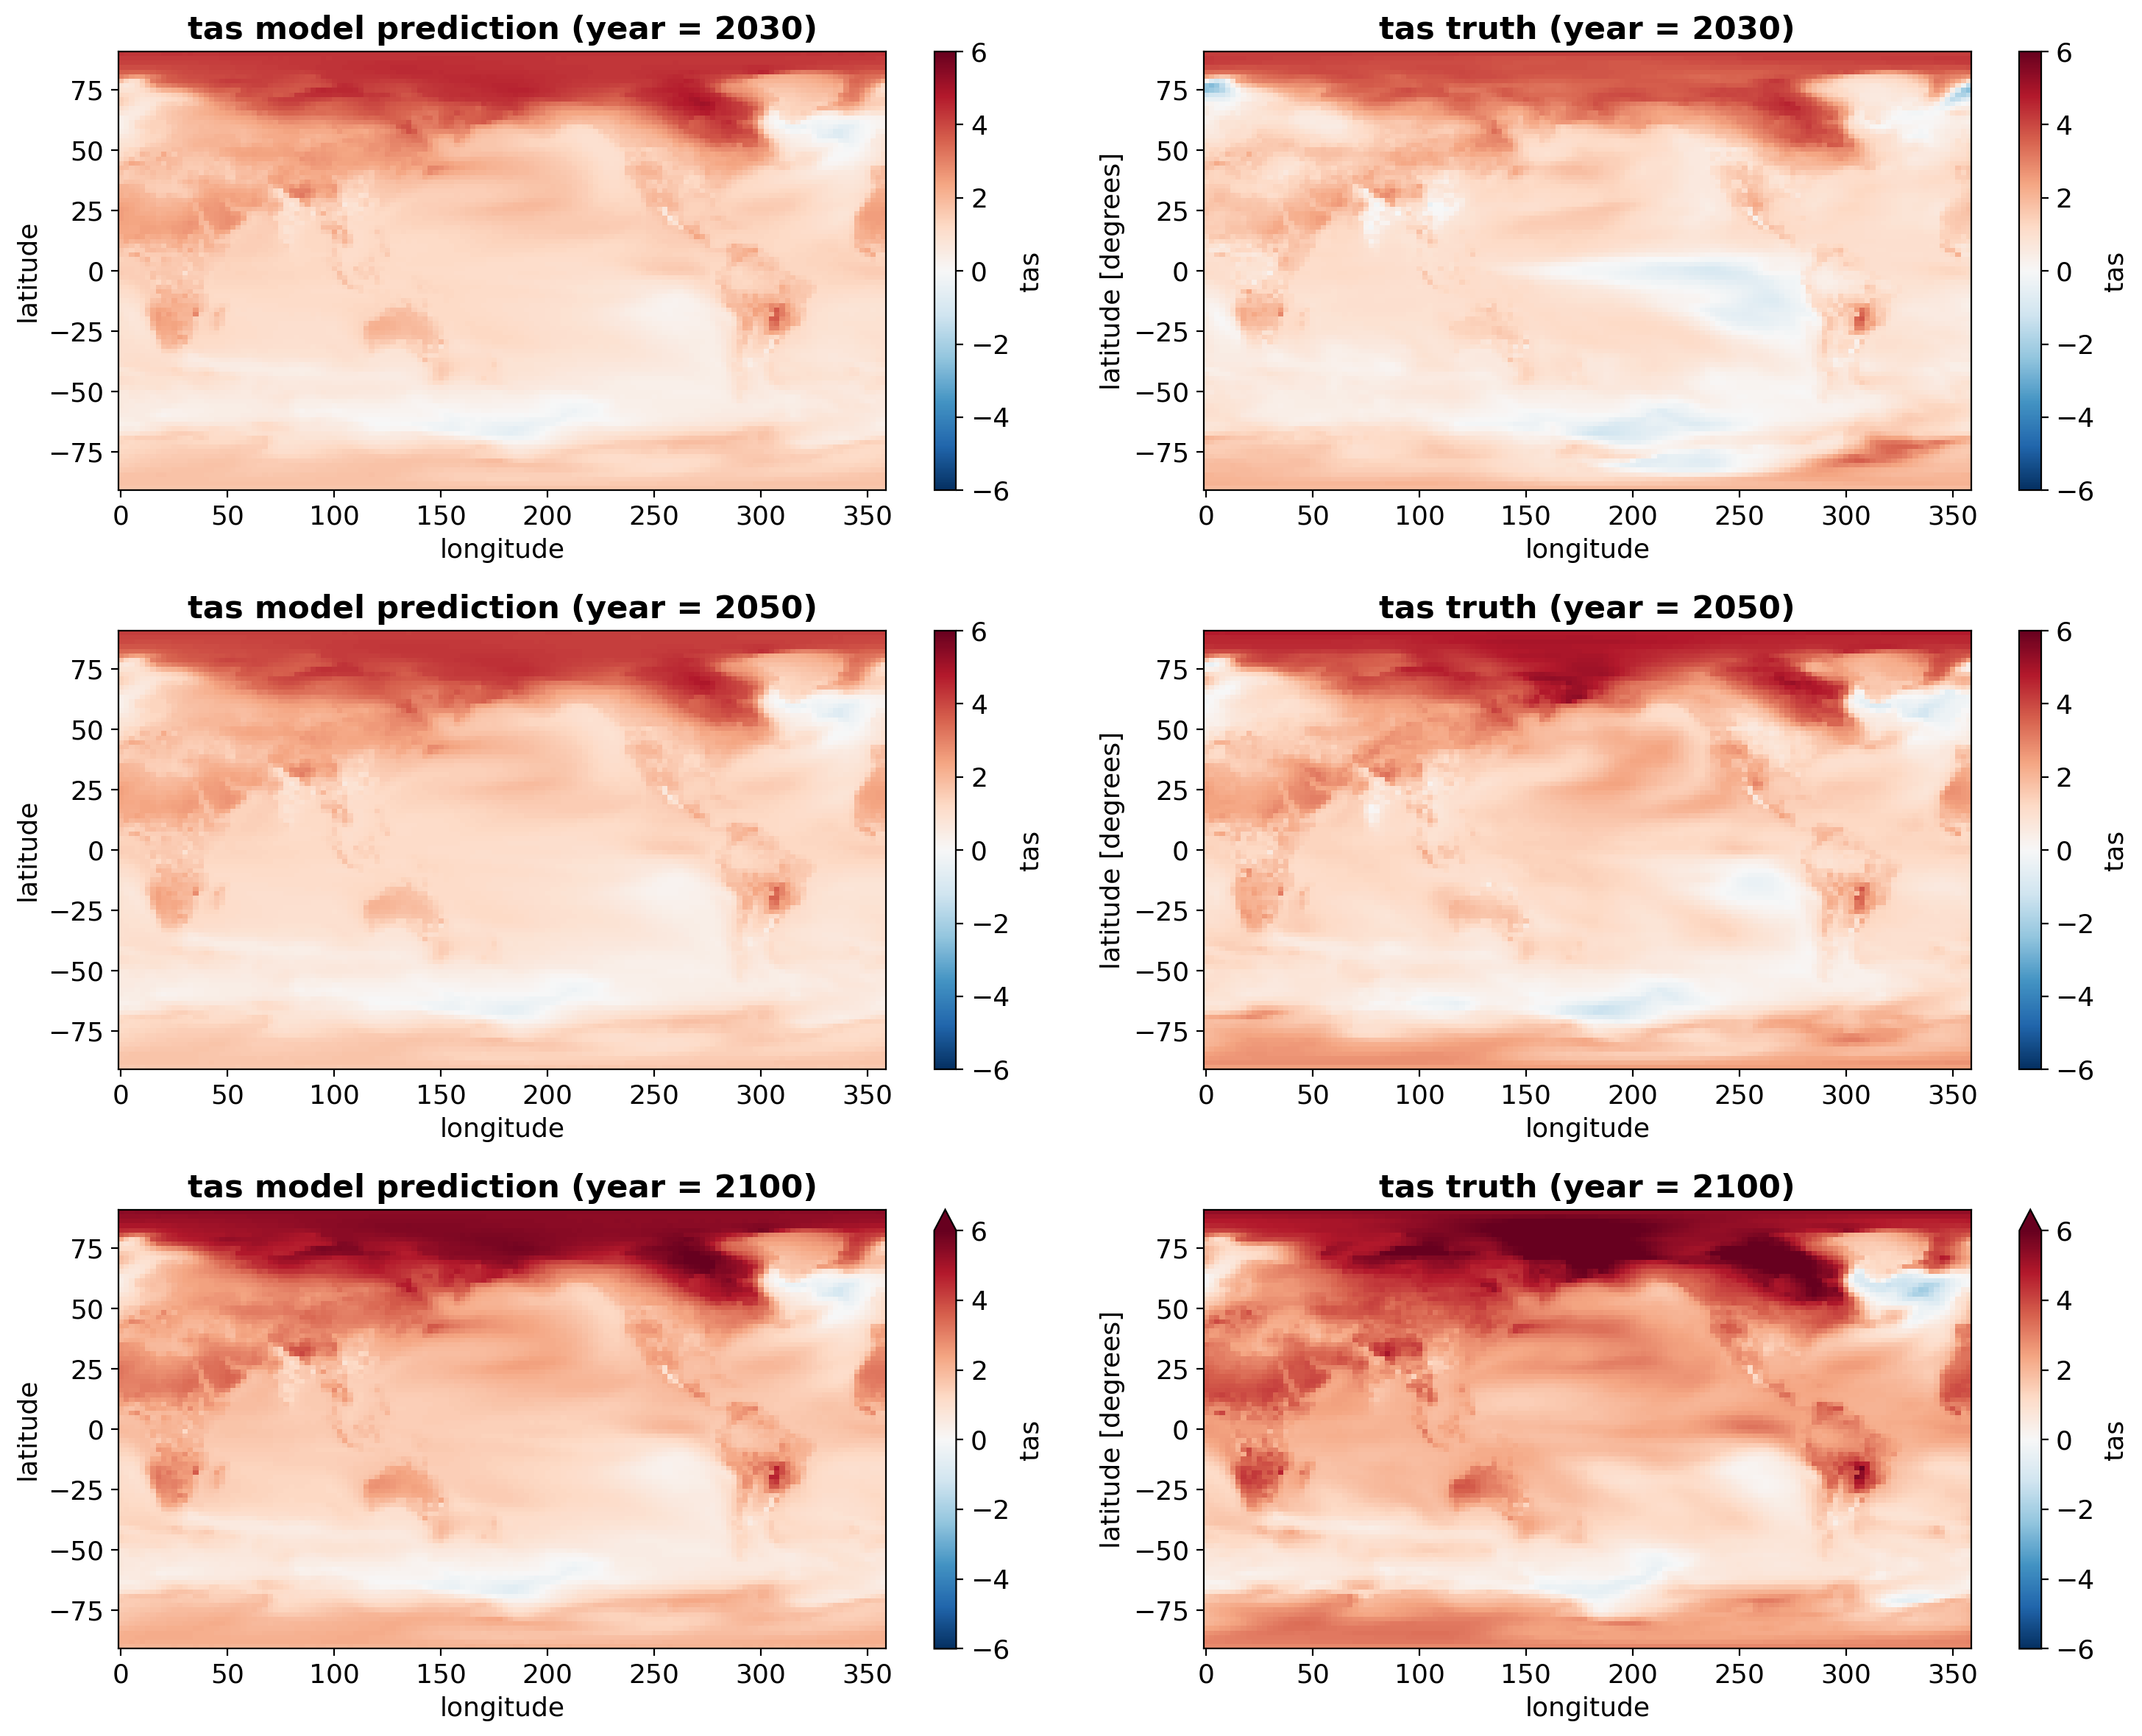

In [16]:
fig, axes = plt.subplots(figsize=(15,12),ncols=2,nrows=3)

yrs = [2030, 2050, 2100]
vmin, vmax    = -6, 6
cmap = 'RdBu_r'
y_test_pre.tas.sel(time=yrs[0]).plot(ax=axes[0,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[0]).plot(ax=axes[0,1], vmin=vmin, vmax=vmax,cmap=cmap)

y_test_pre.tas.sel(time=yrs[1]).plot(ax=axes[1,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[1]).plot(ax=axes[1,1], vmin=vmin, vmax=vmax,cmap=cmap)

y_test_pre.tas.sel(time=yrs[2]).plot(ax=axes[2,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[2]).plot(ax=axes[2,1], vmin=vmin, vmax=vmax,cmap=cmap)


for i, ax in enumerate(axes.flat):
    # left column: model prediction
    if i % 2 == 0:
        ax.set_title(f'tas model prediction (year = {yrs[i//2]})',fontweight='bold')
    # right column: truth tas from ssp245 simulations
    else:
        ax.set_title(f'tas truth (year = {yrs[i//2]})',fontweight='bold')
plt.tight_layout()